# 4.3 - Train a model for each dataset category, comparing it to random data

In [1]:
import os
import datetime
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

import models
import report
import block_sampler
import batch_encoder
from dataset import Dataset
from report import Reporter2
from trainer import Trainer, TrainResults
from batch_encoder import Dataset
from block_sampler import count_sectors, BlockSamplerByFile, RandomSampler
from batch_encoder import xs_encoder_8bits_11, BatchEncoder, xs_encoder_one_hot
from filter_random import gen_rndchk_models, evaluate_rnd_model, filter_dataset

In [7]:
raw_dataset_folder='sample200'
minimum=200
maximum=200
result_dir = 'results/4.3-randomness'
os.makedirs(result_dir, exist_ok=True)

In [3]:
rawset = Dataset.new_from_folders(raw_dataset_folder).filter_min_max(minimum, maximum)
rawset = rawset.filter(lambda x: rawset.category_from(x) not in ['text', 'unk'])
rawset.rebuild_categories()

In [6]:
class CatSampler:
    def __init__(self, model, blksampler, cat):
        self.model = model
        self.blksampler = blksampler
        self.dataset = blksampler.dataset
        self.cat = cat

    def __iter__(self):
        blkiter = iter(self.blksampler)
        fails=0
        while True:
            blks = [next(blkiter) for _ in range(100)] #############3
            encblk = xs_encoder_one_hot([blk.block for blk in blks])
            predict = self.model.predict(encblk)
            predict = np.argmax(predict, axis=-1)
            blks = [x for x,y in zip(blks, predict) if y == self.cat]
            if len(blks) == 0:
                fails += 1
                if fails > 1000:
                    raise Exception("all blocks seems to be the wrong kind")
                continue
            fails=0
            for blk in blks:
                yield blk


In [5]:
class ThrSampler:
    def __init__(self, model, blksampler, threshold, cat):
        self.model = model
        self.blksampler = blksampler
        self.dataset = blksampler.dataset
        self.threshold = threshold
        self.cat = cat

    def __iter__(self):
        blkiter = iter(self.blksampler)
        fails=0
        while True:
            blks = [next(blkiter) for _ in range(100)] #############3
            encblk = xs_encoder_one_hot([blk.block for blk in blks])
            predict = self.model.predict(encblk)
            predict = predict[:,0] - predict[:,1]
            blks = [x for x,y in zip(blks, predict) if y > self.threshold]
            if len(blks) == 0:
                fails += 1
                if fails > 1000:
                    raise Exception("all blocks seems to be the wrong kind")
                continue
            fails=0
            for blk in blks:
                yield blk


In [12]:
import models
from block_sampler import BlockSamplerByCategory
from batch_encoder import BatchEncoder
from collections import namedtuple
import callbacks
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

TrainResults = namedtuple(
    'TrainResults', ['model', 'history', 'metrics', 'elapsed'])

class RandomTrainer:
    def __init__(self,
                 model,
                 xs_encoder='one_hot',
                 validation_steps=4,
                 steps_per_epoch=2,
                 epochs=10000000,
                 max_seconds=None,
                 batch_size=100,
                 min_delta=1e-03,
                 patience=10):
        self.model = model
        self.xs_encoder = xs_encoder
        self.validation_steps = validation_steps
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs
        self.max_seconds = max_seconds
        self.batch_size = batch_size
        self.min_delta = min_delta
        self.patience = patience

    def train(self, tset, vset, previous_model=None):
        tsampler = BlockSamplerByFile(tset)
        if previous_model:
            tsampler = CatSampler(previous_model, tsampler, 0)
        trsampler = RandomSampler(tsampler, rnd_cat='zzz', not_rnd_cat=tset.categories[0])
        tbenc = BatchEncoder(trsampler, self.batch_size,
                             xs_encoder=self.xs_encoder)

        vsampler = BlockSamplerByFile(vset)
        if previous_model:
            vsampler = CatSampler(previous_model, vsampler, 0)
        vrsampler = RandomSampler(vsampler, rnd_cat='zzz', not_rnd_cat=vset.categories[0])
        vbenc = BatchEncoder(vrsampler, self.batch_size,
                             xs_encoder=self.xs_encoder)

        return self._train(tbenc,vbenc)

    def _train(self, tbenc, vbenc):
        model = self.model

        timeIt = callbacks.TimeIt()

        history = model.fit_generator(iter(tbenc),
                                      validation_data=iter(vbenc),
                                      validation_steps=self.validation_steps,
                                      steps_per_epoch=self.steps_per_epoch,
                                      epochs=self.epochs,
                                      verbose=0,
                                      callbacks=[
            timeIt,
            # callbacks.SaveModel(os.path.join(result_dir, model.name + '.h5')),
#             callbacks.TimeLimit(self.max_seconds),
            EarlyStopping(monitor='val_categorical_accuracy',
                          min_delta=self.min_delta, patience=self.patience),
            # TensorBoard(
            #     log_dir=os.path.join(log_dir, model.name),
            #     # update_freq=3100,
            # ),
#             LambdaCallback(on_epoch_end = lambda epoch, logs: print(logs['val_categorical_accuracy'])),
        ],
#             use_multiprocessing=False,
#             workers=0,
        )
        return TrainResults(
            model=model,
            history=history,
            metrics=['val_binary_accuracy', 'val_categorical_accuracy'],
            elapsed=timeIt.elapsed,
        )

# Train pass1 models

In [14]:
r = Reporter2(result_dir + "/pass1.tsv")
by_category = rawset.by_category()
for cat, dataset in by_category.items():
    val_acc = 0.5
    print(cat)
    dataset.rebuild_categories(categories=[cat, 'zzz'])
    tset, vset = dataset.rnd_split_fraction_by_category(0.5)
    model = models.C256_16_16_L128_D(
        2, 256, 'softmax', 'categorical_crossentropy')
    result = RandomTrainer(
        model,
        batch_size=100,
        steps_per_epoch=2,
        validation_steps=2*2,
        patience=10,
    ).train(tset, vset)
    val_acc = result.history.history['val_categorical_accuracy'][-1]
    print('val_acc =', val_acc)
    r.line(category=cat,
           val_acc=val_acc,
           **report.report_elapsed(**result._asdict()),
           **report.report_epochs(**result._asdict()),
          )
    h5_path = os.path.join(result_dir, '%s_pass1.h5' % cat)
    tf.keras.Model.save(model, h5_path)
r.close()

sql
val_acc = 1.0
dbase3
val_acc = 1.0
ps


KeyboardInterrupt: 

# Load data

In [8]:
data = pd.read_csv(result_dir + '/pass1.tsv', sep='\t')
data = data.sort_values('val_acc')
data

FileNotFoundError: [Errno 2] File b'results/4.3-randomness/pass1.tsv' does not exist: b'results/4.3-randomness/pass1.tsv'

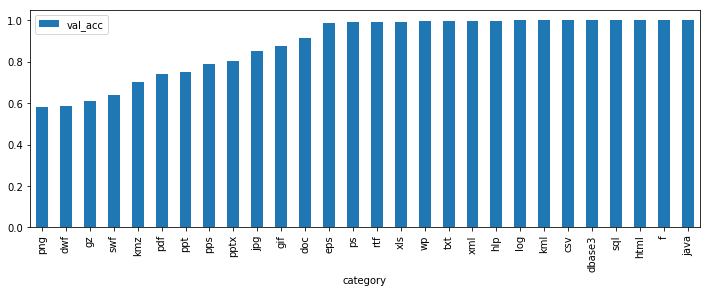

In [10]:
data.plot.bar('category', ['val_acc'], figsize=(12,4))
plt.show()

# Train pass2 models

In [6]:
# r = Reporter2(result_dir + "/pass2.tsv")
by_category = rawset.by_category()
for cat, dataset in by_category.items():
    if data.set_index('category').loc[cat].val_acc > 0.98:
        continue
    previous_model = tensorflow.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)
    dataset.rebuild_categories(categories=[cat, 'zzz'])
    tset, vset = dataset.rnd_split_fraction_by_category(0.5)
    model = models.C256_16_16_L128_D(
        2, 256, 'softmax', 'categorical_crossentropy')
    print(cat)
    
    tsampler = BlockSamplerByFile(tset)
    tsampler = ThrSampler(previous_model, tsampler, cat)
    tsampler = RandomSampler(tsampler, rnd_cat='zzz', not_rnd_cat=tset.categories[0])
    tbenc = BatchEncoder(tssampler, 100,
                         xs_encoder='one_hot')

    vsampler = BlockSamplerByFile(vset)
    vsampler = ThrSampler(previous_model, vsampler, cat)
    vsampler = RandomSampler(vsampler, rnd_cat='zzz', not_rnd_cat=vset.categories[0])
    vbenc = BatchEncoder(vsampler, 100,
                         xs_encoder='one_hot')

    result = RandomTrainer(model, 
                           batch_size=100, 
                           steps_per_epoch=28, 
                           patience=10)._train(tbenc,vbenc)
    val_acc = result.history.history['val_categorical_accuracy'][-1]
    print('val_acc =', val_acc)
#     r.line(category=cat,
#            val_acc=val_acc,
#            **report.report_elapsed(**result._asdict()),
#            **report.report_epochs(**result._asdict()),
#           )
    h5_path = os.path.join(result_dir, '%s_pass2.h5' % cat)
#     tensorflow.keras.Model.save(model, h5_path)
# r.close()

NameError: name 'data' is not defined

# Load pass2 data

In [11]:
data2 = pd.read_csv('results/exp43/pass2.tsv', sep='\t')
data2 = data2.sort_values('val_acc')
data2

,category,val_acc,Time,Epochs
4,dwf,0.96,2m38s,5
6,gz,0.97,3m21s,5
11,png,0.97,2m44s,5
2,jpg,0.99,2m05s,5
0,doc,1.00,1m23s,5
1,pdf,1.00,2m09s,5
3,swf,1.00,2m41s,5
5,gif,1.00,2m04s,5
7,ppt,1.00,3m56s,5
8,pptx,1.00,5m14s,6


# Use models to evaluate dataset

In [52]:
r = Reporter2(result_dir + "/evaluate.tsv")
by_category = rawset.by_category()
for cat, dataset in by_category.items():
    model = tensorflow.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)
    tsampler = BlockSamplerByFile(dataset)
    tbenc = BatchEncoder(tsampler,
                         batch_size=100,
                         xs_encoder='one_hot')
    predict = model.predict_generator(iter(tbenc),
                                      steps=10)
    predict = np.argmax(predict, axis=-1)
    not_random = len(predict[predict==0])/len(predict)
    print(cat, not_random)
    r.line(cat=cat, not_random=not_random)
r.close()

kml 1.0
sql 0.998
doc 0.846
f 0.999
pdf 0.495
eps 0.987
dbase3 1.0
csv 1.0
jpg 0.897
hlp 1.0
swf 0.436
dwf 0.394
ps 0.98
rtf 0.993
html 1.0
gif 0.867
java 1.0
gz 0.451
ppt 0.515
xml 0.997
wp 0.993
log 0.999
xls 0.982
pptx 0.65
kmz 0.554
pps 0.797
txt 0.999
png 0.543


# Load not_random data

In [17]:
data3 = pd.read_csv('results/exp43/evaluate.tsv', sep='\t')
data3 = data3.sort_values('not_random')
data3

,cat,not_random
11,dwf,0.394
10,swf,0.436
17,gz,0.451
4,pdf,0.495
18,ppt,0.515
27,png,0.543
24,kmz,0.554
23,pptx,0.650
25,pps,0.797
2,doc,0.846


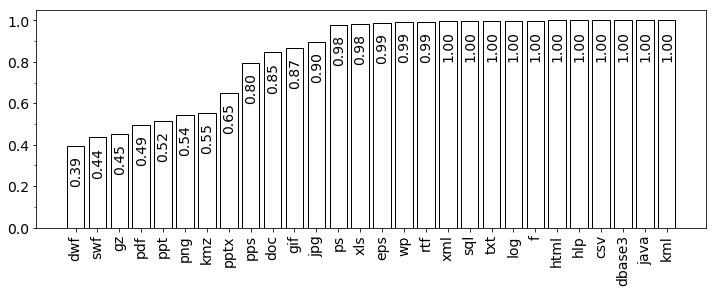

In [18]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(figsize=(12,4))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
# plt.grid(linestyle='--', which='minor')
ax.bar(data3['cat'], data3['not_random'], fill=False)
plt.xticks(rotation='vertical')
ax.tick_params(labelsize=14)
for i in range(28):
    cat = rawset.ix_to_cat[i]
    v = data3.iloc[i,1]
    t = ax.annotate('%0.2f'%v, (i-0.3, v-0.1),fontsize=14)
    t.set_rotation(90)
# data3.plot.bar('cat', ['not_random'], figsize=(12,4))
# plt.show()

In [19]:
data3.mean()

not_random    0.834714
dtype: float64

In [27]:
1-np.sum(data3['not_random'])/28

0.16528571428571426

In [35]:
1-(np.sum(data3['not_random'])+(1-0.39))/28

0.14350000000000007

In [33]:
1-(0.39+0.44+0.45+0.49+0.52+0.54+0.55+0.65+0.8+0.85+0.87+0.9+0.98+0.98+0.99+0.99+0.99+11)/28

0.16499999999999992

In [34]:
1-(1+0.44+0.45+0.49+0.52+0.54+0.55+0.65+0.8+0.85+0.87+0.9+0.98+0.98+0.99+0.99+0.99+11)/28

0.14321428571428563

# Train pass3 models - measure random

In [38]:
def f():
    cat = 'kmz'
    by_category = rawset.by_category()
    dataset = by_category[cat]
    previous_model = tensorflow.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)
    dataset.rebuild_categories(categories=[cat, 'zzz'])
    tset, vset = dataset.rnd_split_fraction_by_category(0.5)
    tsampler = BlockSamplerByFile(tset)
    tsampler = CatSampler(previous_model, tsampler,1)
    tbenc = BatchEncoder(tsampler, batch_size=10,xs_encoder='one_hot')
    batch, _ = next(iter(tbenc))
    predict = previous_model.predict(batch)
    print(np.argmax(predict, axis=-1))
f()

[1 1 1 1 1 1 1 1 1 1]


In [43]:
r = Reporter2(result_dir + "/pass3.tsv")
by_category = rawset.by_category()
for cat, dataset in by_category.items():
    if data.set_index('category').loc[cat].val_acc > 0.98:
        continue
    val_acc = 0.5
    print(cat)
    dataset.rebuild_categories(categories=[cat, 'zzz'])
    tset, vset = dataset.rnd_split_fraction_by_category(0.5)
    
    previous_model = tensorflow.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)
    tsampler = BlockSamplerByFile(tset)
    tsampler = CatSampler(previous_model, tsampler,1)
    tsampler = RandomSampler(tsampler, rnd_cat='zzz', not_rnd_cat=tset.categories[0])
    tbenc = BatchEncoder(tsampler, batch_size=100,xs_encoder='one_hot')
    
    vsampler = BlockSamplerByFile(vset)
    vsampler = CatSampler(previous_model, vsampler,1)
    vsampler = RandomSampler(vsampler, rnd_cat='zzz', not_rnd_cat=vset.categories[0])
    vbenc = BatchEncoder(vsampler, batch_size=100,xs_encoder='one_hot')
       
    model = models.C256_16_16_L128_D(
        2, 256, 'softmax', 'categorical_crossentropy')
    mytrainer = RandomTrainer(model, batch_size=100, steps_per_epoch=10)
    result = mytrainer._train(tbenc,vbenc)
    val_acc = result.history.history['val_categorical_accuracy'][-1]
    print('val_acc =', val_acc)
    r.line(category=cat,
           val_acc=val_acc,
           **report.report_elapsed(**result._asdict()),
           **report.report_epochs(**result._asdict()),
          )
    h5_path = os.path.join(result_dir, '%s_pass3.h5' % cat)
    tensorflow.keras.Model.save(model, h5_path)
r.close()

pptx
0.485
0.4995
0.508
0.492
0.5245
0.523
0.517
0.542
0.526
0.493
0.5045
0.5145
val_acc = 0.5145
dwf
0.5285
0.5225
0.55
0.5635
0.5405
0.564
0.576
0.6015
0.596
0.59
0.5985
0.567
val_acc = 0.567
ppt
0.5135
0.5
0.5155
0.549
0.517
0.544
0.546
0.5435
val_acc = 0.5435
doc
0.5525
0.5475
0.5975
0.6205
0.631
0.6485
0.653
0.6525
0.6565
0.663
0.6425
0.636
0.6525
0.674
0.64
0.644
val_acc = 0.644
pdf
0.4985
0.4995
0.526
0.4905
0.487
0.4805
0.5255
val_acc = 0.5255
kmz
0.493
0.5135
0.496
0.521
0.499
0.5135
0.5165
0.5135
val_acc = 0.5135
gz
0.5345
0.5265
0.543
0.528
0.5385
0.5445
0.5415
0.586
0.548
0.576
0.579
0.5835
val_acc = 0.5835
jpg
0.5045
0.5145
0.5135
0.547
0.5325
0.555
0.5425
0.548
0.5195
0.5805
0.5605
0.5445
0.541
0.5495
val_acc = 0.5495
pps
0.5055
0.5135
0.477
0.4965
0.5085
0.519
0.5135
0.519
0.503
0.5355
0.541
0.5045
0.508
0.512
0.5325
val_acc = 0.5325
swf
0.5145
0.515
0.5405
0.5055
0.522
0.548
0.5585
0.514
0.5305
0.5305
0.566
0.5565
0.5775
0.591
0.5785
0.61
0.5835
0.581
0.576
0.6035
val_a

# Train pass4

In [44]:
r = Reporter2(result_dir + "/pass4.tsv")
by_category = rawset.by_category()
for cat, dataset in by_category.items():
    if data.set_index('category').loc[cat].val_acc > 0.98:
        continue
    print(cat)
    dataset.rebuild_categories(categories=[cat, 'zzz'])
    tset, vset = dataset.rnd_split_fraction_by_category(0.5)
    
    previous_model1 = tensorflow.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)
    previous_model3 = tensorflow.keras.models.load_model(result_dir + '/%s_pass3.h5' % cat)
    tsampler = BlockSamplerByFile(tset)
    tsampler = CatSampler(previous_model1, tsampler,1)
    tsampler = CatSampler(previous_model3, tsampler,0)
    tsampler = RandomSampler(tsampler, rnd_cat='zzz', not_rnd_cat=tset.categories[0])
    tbenc = BatchEncoder(tsampler, batch_size=100,xs_encoder='one_hot')
    
    vsampler = BlockSamplerByFile(vset)
    vsampler = CatSampler(previous_model1, vsampler,1)
    vsampler = CatSampler(previous_model3, vsampler,0)
    vsampler = RandomSampler(vsampler, rnd_cat='zzz', not_rnd_cat=vset.categories[0])
    vbenc = BatchEncoder(vsampler, batch_size=100,xs_encoder='one_hot')
    
    model = models.C256_16_16_L128_D(
        2, 256, 'softmax', 'categorical_crossentropy')
    result = RandomTrainer(model, batch_size=100, steps_per_epoch=10)._train(tbenc, vbenc)
    val_acc = result.history.history['val_categorical_accuracy'][-1]
    print('val_acc =', val_acc)
    r.line(category=cat,
           val_acc=val_acc,
           **report.report_elapsed(**result._asdict()),
           **report.report_epochs(**result._asdict()),
          )
    h5_path = os.path.join(result_dir, '%s_pass4.h5' % cat)
    tensorflow.keras.Model.save(model, h5_path)
r.close()

pptx
0.5595
0.5745
0.582
0.5905
0.6095
0.6195
0.63
0.6465
0.638
0.613
0.643
0.65
0.6435
0.6555
val_acc = 0.6555
dwf
0.544
0.6925
0.653
0.738
0.688
0.716
0.75
0.757
0.755
0.7575
0.7425
0.752
val_acc = 0.752
ppt
0.589
0.7135
0.739
0.752
0.7585
0.766
0.772
0.8015
0.8015
0.792
0.7895
val_acc = 0.7895
doc
0.706
0.733
0.7665
0.7905
0.736
0.749
0.777
val_acc = 0.777
pdf
0.517
0.58
0.594
0.598
0.5985
0.596
0.62
0.6305
0.6005
0.643
0.629
0.6045
0.628
0.658
0.626
val_acc = 0.626
kmz
0.55
0.5275
0.5865
0.532
0.5095
0.531
0.54
val_acc = 0.54
gz
0.6085
0.62
0.656
0.6755
0.739
0.7305
0.7255
0.728
0.747
0.761
0.754
0.7255
0.7475
0.7165
val_acc = 0.7165
jpg
0.5085
0.593
0.594
0.6255
0.5825
0.633
0.6155
0.6185
val_acc = 0.6185
pps
0.5245
0.5435
0.5795
0.6165
0.6185
0.642
0.659
0.64
0.675
val_acc = 0.675
swf
0.5255
0.5935
0.636
0.657
0.7455
0.759
0.734
0.7165
0.768
0.767
0.7505
0.7685
0.7815
0.7785
0.7915
val_acc = 0.7915
gif
0.531
0.6535
0.5845
0.599
0.6165
0.6165
val_acc = 0.6165
png
0.534
0.57
0.572
